# Introduction to image data

In computer vision, we normally solve one of the following problems:

* **Image Classification** is the simplest task, when we need to classify an image into one of many pre-defined categories, for example, distinguish a cat from a dog on a photograph, or recognize a handwritten digit.

* **Object Detection** is a bit more difficult task, in which we need to find known objects on the picture and localize them, i.e. return the **bounding box** for each of recognized objects.

* **Segmentation** is similar to object detection, but instead of giving bounding box we need to return an exact pixel map outlining each of the recognized objects.  

![An image showing how computer vision object detection can be performed with cats, dogs, and ducks.](https://i.stack.imgur.com/mFBCV.png)

Image taken from [CS224d Stanford Course](https://cs224d.stanford.edu/index.html)

## Images as Tensors

Computer Vision works with Images. As you probably know, images consist of pixels, so they can be thought of as a rectangular collection (array) of pixels.

In the first part of this tutorial, we will deal with handwritten digit recognition. We will use the MNIST dataset, which consists of grayscale images of handwritten digits, 28x28 pixels. Each image can be represented as 28x28 array, and elements of this array would denote intensity of corresponding pixel - either in the scale of range 0 to 1 (in which case floating point numbers are used), or 0 to 255 (integers). A popular python library called `numpy` is often used with computer vision tasks, because it allows to operate with multidimensional arrays effectively.

To deal with color images, we need some way to represent colors. In most cases, we represent each pixel by 3 intensity values, corresponding to Red (R), Green (G) and Blue (B) components. This color encoding is called RGB, and thus color image of size $W\times H$ will be represented as an array of size $H\times W\times 3$ (sometimes the order of components might be different, but the idea is the same).

Multi-dimensional arrays are also called **tensors**. Using tensors to represent images also has an advantage, because we can use an extra dimension to store a sequence of images. For example, to represent a video fragment consisting of 200 frames with 800x600 dimension, we may use the tensor of size 200x600x800x3.

## TensorFlow and Keras versions


In [1]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install setuptools


#Import the packages needed.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
2.17.0


TensorFlow is now at version 2, and it differs significantly between versions 1 and 2. Thus it is important to check that we have correct version, otherwise the code is likely not to work.

In version 2 TensorFlow added a higher-level neural network construction API called [**Keras**](http://keras.io). With Keras, most model building steps can be done in a much simpler way. This has made Keras a preferred way to start training deep learning networks. Only switching to pure TensorFlow when you need to develop some custom architectures for research or more complex scenarios. Since Keras is part of TensorFlow, the terms are used interchangeably and many times when someone says TensorFlow they are actually talking about the Keras.

In this tutorial, we will focused on developing neural networks using **Keras** in **TensorFlow 2**.

## Loading the MNIST Dataset

Keras has a [number of datasets](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets) available right from the library. Here we are using the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, available through `tf.keras.datasets.mnist`. It has a function `load_data()` that returns train and test MNIST datasets.

When using your own notebooks, you can experiment with the other built in datasets, in particular [FashionMNIST](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets/fashion_mnist). It has exactly the same shape as MNIST, but contains outlines of different clothing types. You should be able to experiment with FashionMNIST by simply replacing the dataset name below.

> **Note**: When running this sample code locally, data would automatically be downloaded, you can just call `load_data()` without parameters. For the sandbox environment, we need to pre-fetch the data locally in advance, before calling `load_data`. If you are running on a local notebook, you can ignore the next cell:

In [2]:
import os
import requests

# Crear el directorio si no existe
# directory = os.path.expanduser('~/.keras/datasets')
directory = os.path.dirname(os.path.abspath('2-image-data.ipynb'))
os.makedirs(directory, exist_ok=True)

# Descargar el archivo
url = 'https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/data/mnist.npz'
response = requests.get(url)
file_path = os.path.join(directory, 'mnist.npz')

with open(file_path, 'wb') as file:
    file.write(response.content)

print(f'Archivo descargado en: {file_path}')

Archivo descargado en: c:\Proyectos_De_Acceso_Rapido\TensorFlow_Fundamentals\Introduction_To_Image_Data\mnist.npz


In [3]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualize the digits dataset
Now that we have downloaded the dataset we can visualize some of the digits

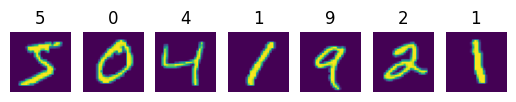

In [5]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(x_train[i])
    ax[i].set_title(y_train[i])
    ax[i].axis('off')

## Dataset structure

We have a total of 60000 training images (stored in `x_train`) and 10000 testing images (in `x_test`). Labels corresponding to those images are contained in `y_train` and `y_test` accordingly.

In [6]:
print('Training samples:',len(x_train))
print('Test samples:',len(x_test))

print('Tensor size:',x_train[0].shape)
print('First 10 digits are:', y_train[:10])
print('Type of data is ',type(x_train))

Training samples: 60000
Test samples: 10000
Tensor size: (28, 28)
First 10 digits are: [5 0 4 1 9 2 1 3 1 4]
Type of data is  <class 'numpy.ndarray'>


As you can see, the type of data is numpy array, which allows us to manipulate it using any numpy operations. All pixels of the images are represented by integer numbers from 0 to 255:

In [7]:
print('Min intensity value: ',x_train.min())
print('Max intensity value: ',x_train.max())

Min intensity value:  0
Max intensity value:  255


The reason it is between 0 and 255 is because of how color is represented in a binary format. RGB (red, green, blue) are each represented as a 0-255 value to create digital colors.  If we load any image from file using [OpenCV](https://opencv.org/) or [PIL](https://pillow.readthedocs.io/en/stable/) you will end up having numpy array with pixel intensities in the same range [0..255].

> Note: If you are loading color image, the shape of the array would be slightly different, each pixel contains 3 color values (R,G and B). Thus the image 300x300 pixels will be represented by 300x300x3 numpy array.

If we want to feed our images to the neural network, it is important to make sure that all values are scaled to the range [**0 - 1**] before we start training. So, we will rescale the dataset in order to have all values in the required normalized range:

In [8]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

Now we have the data, and we are ready to start training our first neural network!